In [1]:
# Chargement des modules necessaire :

import os

import cv2, numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import cv2, numpy as np

In [2]:
# On declare les chemins vers les donnees :

# Image = 'Data'
        
train_data_dir = 'cleaned_data/spectrogram_train_test/Train'
validation_data_dir = 'cleaned_data/spectrogram_train_test/Test'
#test_data_dir = '../../spectrogramm/test'

# Dimmension et path : 
img_width, img_height = 336, 336 #224

ImageTRAINCOVID = os.listdir(train_data_dir + '/Cov')
ImageTRAINNORMAL = os.listdir(train_data_dir + '/noncovid')

ImageVALIDATIONCOVID = os.listdir(validation_data_dir + '/Cov')
ImageVALIDATIONNORMAL = os.listdir(validation_data_dir + '/noncovid')

#ImageTESTCOVID = os.listdir(test_data_dir + '/Covid-19')
#ImageTESTNORMAL = os.listdir(test_data_dir + '/spectro_healthy')

print('Il y a ' + str(len(ImageTRAINCOVID)) + ' images d\'entrainement de patient covid.') 
print('Il y a ' + str(len(ImageTRAINNORMAL)) + ' images d\'entrainement de patient non-covid.\n') 

print('Il y a ' + str(len(ImageVALIDATIONCOVID)) + ' images de validation de patient covid.') 
print('Il y a ' + str(len(ImageVALIDATIONNORMAL)) + ' images de validation de patient non-covid.\n')

#print('Il y a ' + str(len(ImageTESTCOVID)) + ' images de test de patient covid.') 
#print('Il y a ' + str(len(ImageTESTNORMAL)) + ' images de test de patient non-covid.')

Il y a 193 images d'entrainement de patient covid.
Il y a 865 images d'entrainement de patient non-covid.

Il y a 97 images de validation de patient covid.
Il y a 289 images de validation de patient non-covid.



In [3]:
# Preprocessing :
# On rescale les images :
datagen = ImageDataGenerator(rescale=1./255)

# On definit la batch size :
batch_size = 32

# On prepare les tableaux de donnees depuis les images :
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

# On prepare les tableaux de donnees depuis les images :
validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=True)

#test_generator_bottleneck = datagen.flow_from_directory(
        #test_data_dir,
        #target_size=(img_width, img_height),
        #batch_size=batch_size,
        #class_mode=None,
        #shuffle=True)




Found 1056 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [4]:
# Chargement de VGG16 sans la partie fully-connected avec le reseau convolutif entrainer sur imagenet :

model_vgg = applications.VGG19(include_top=False, weights='imagenet')

In [5]:
# On utilse le model VGG16 pour extraire les features de nos images 
# (on fait recupere la sortie du reseau convolutionnel) :
train_features = model_vgg.predict_generator(train_generator_bottleneck, 1056 // batch_size)
validation_features = model_vgg.predict_generator(validation_generator_bottleneck, 384 // batch_size)
#test_features = model_vgg.predict_generator(test_generator_bottleneck, 1560 // batch_size)

/Users/baudouin/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:2040: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/Users/baudouin/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:2040: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
# L'opération étant longue on enregistre les features obtenus :

np.save(open('models/models/trainFeatures_VGG19_AllData.npy', 'wb'), train_features) # ecriture en binaire necessaire
np.save(open('models/models/validationFeatures_VGG19_AllData.npy', 'wb'), validation_features) # Idem

#np.save(open('models/testFeatures_VGG16_AllData.npy', 'wb'), test_features) # Idem

In [10]:
# Si l'operation à deja été effectuer on charge les features :

train_features = np.load(open('models/models/trainFeatures_VGG19_AllData.npy', 'rb'))
validation_features = np.load(open('models/models/validationFeatures_VGG19_AllData.npy', 'rb'))

#test_features = np.load(open('models/testFeatures_VGG16_AllData.npy', 'rb'))

In [7]:
# On definit les labels :

train_labels = np.array([0] * 864 + [1] * 192)
validation_labels = np.array([0] * 288 + [1] * 96 )
#test_labels = np.array([0] * 219 + [1] * 1317)

In [16]:
# modele :
model_top3 = Sequential()
model_top3.add(Flatten(input_shape=train_features.shape[1:])) #Flatten layers are used when you got a multidimensional output and you want to make it linear to pass it onto a Dense layer.
model_top3.add(Dense(128, activation='relu')) #Dense layers are used when association can exist among any feature to any other feature in data point.
model_top3.add(Dropout(0.5)) #Dropout is a way of cutting too much association among features by dropping the weights (edges) at a probability.
model_top3.add(Dense(1, activation='sigmoid'))

# On compile :
model_top3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 6,553,857
Trainable params: 6,553,857
Non-trainable params: 0
_________________________________________________________________


In [9]:
# On definit les parametres pour l'entrainement :
epochs = 100


# On definit les callbacks : 
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='accuracy',mode='max',patience = 10,restore_best_weights=True,),
]

In [10]:
# On entraine le modèle:
historique3 = model_top3.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))



Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
33/33 [==============================] - 3s 63ms/step - loss: 1.3268 - accuracy: 0.7888 - val_loss: 0.6237 - val_accuracy: 0.7500
Epoch 2/100
33/33 [==============================] - 2s 51ms/step - loss: 0.5641 - accuracy: 0.8059 - val_loss: 0.9626 - val_accuracy: 0.7500
Epoch 3/100
33/33 [==============================] - 2s 55ms/step - loss: 0.4961 - accuracy: 0.8182 - val_loss: 0.7418 - val_accuracy: 0.7500
Epoch 4/100
33/33 [==============================] - 2s 54ms/step - loss: 0.4909 - accuracy: 0.8182 - val_loss: 0.7439 - val_accuracy: 0.7500
Epoch 5/100
33/33 [==============================] - 2s 52ms/step - loss: 0.4893 - accuracy: 0.8182 - val_loss: 0.7937 - val_accuracy: 0.7500
Epoch 6/100
33/33 [==============================] - 2s 52ms/step - loss: 0.4811 - accuracy: 0.8182 - val_loss: 0.7234 - val_accuracy: 0.7500
Epoch 7/10

In [12]:
n_epochs = len(historique3.history['accuracy'])
GenOptimale3 = n_epochs-10
print("La generation optimale est : ",GenOptimale3)
print("Avec une accuracy de : ",historique3.history['accuracy'][GenOptimale3-1])
model_top3.save_weights('weights/vgg19_heavyTop_224_224_'+str(GenOptimale3)+'.h5')

La generation optimale est :  3
Avec une accuracy de :  0.8181818127632141


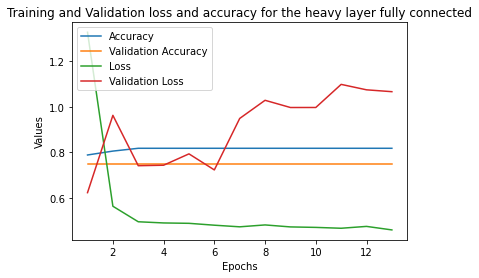

In [13]:
epochs = range(1,n_epochs+1)
plt.plot(epochs, historique3.history['accuracy'], label='Accuracy')
plt.plot(epochs, historique3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, historique3.history['loss'], label='Loss')
plt.plot(epochs, historique3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the heavy layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()